In [2]:
from common import *

os.environ["LATEXIFY"] = ""
os.environ["FIG_DIR"] = "."
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

X (200, 1) y (200,)
min_indices [ 89 280  -1 397 116 562 810 172 132  -1]
individual restart losses [505.19096545 463.94862837          nan 439.15678891 460.48359921
 442.76861082 466.80603809 441.20138721 497.68771049          nan]
best_restart 3 best_loss 439.15678891077994


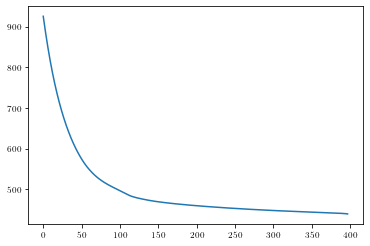

In [5]:
%matplotlib inline
seed = 0
key = jax.random.PRNGKey(0)
num_inducing = 20
inducing_type = "random"
optimizer = optax.adam(learning_rate=0.01)
num_epochs = 1000
num_restarts = 10
flex_scale=True
flex_var=True
flex_noise=True

# scale_prior = tfd.Normal(0.0, 1.0)
scale_prior = tfb.Log()(tfd.Gamma(5.0, 1.0))
# scale_prior = None

# var_prior = tfb.Log()(tfd.HalfCauchy(0.0, 1.0))
var_prior = tfb.Log()(tfd.Gamma(0.5, 1.0))
# var_prior = None

std_prior = tfd.Normal(0.0, 1.0)

B.epsilon = 1e-6
jnp.jitter = B.epsilon

################ Motorcycle helmet data

# X, y, _ = rd.MotorcycleHelmet().get_data()
# X_test = jnp.linspace(-3, 3.5, 200).reshape(-1, 1)

################ Heinonen4 data
# X, y, _ = rd.Heinonen4().get_data()
# X_test = jnp.linspace(-3, 3.5, 200)

################ Step data
# X, y, X_test = rd.Step().get_data()
# X_test = X_test * 1.5

################ Olympic
# X, y, X_test = rd.Olympic().get_data()
# X_test = X_test * 1.5

################ Jump1D data
# X, y, _ = rd.Jump1D().get_data()
# X_test = jnp.linspace(-3, 3.5, 200)

################ Smooth 1D
# X, y, _ = rd.Smooth1D().get_data()
# X_test = jnp.linspace(-3, 3.5, 200)

################ Yarin Gal Step data 

# X, y = get_step_data()
# X_test = jnp.linspace(-3, 3.5, 300)

################ AG Wilson Step data
# X, y = get_aw_step()
# X_test = jnp.linspace(-6, 6, 500)

################ Simulated data
# X, y, true_fn, lengthscale_trend, variance_trend, noise_var_trend = get_simulated_data1()
# X_test = jnp.linspace(-10, 10, 400)

################ Synth1D
# seeder = 3
# print("seed", seeder)
# key = jax.random.PRNGKey(seeder)
#     X, y, func_dict, true_fn = get_synth1d(key)
#     X_test = X

################ Tdata
# X, y, f, varf, nvarf = Tdata()
# X_test = jnp.linspace(-8, 8, 400)

################ Heinonen data
# X, y = get_heinonen('Dlso')
# X_test = jnp.linspace(-0.5, 1.5, 200)

################ Heinonen 2D data
# X, y = get_heinonen_2d(n=25, seed=2)
# X_test, y_test = get_heinonen_2d(n=40, seed=1, test=True)

################ Self generated data
key = jax.random.PRNGKey(1221)
X, y, func_dict, true_fn = get_synth1d(key=key, n_points=200)
X_test = jnp.linspace(-40, 40, 200).reshape(-1, 1)

# X_ = X.copy()
# y_ = y.copy()
# X_test_ = X_test.copy()

# x_scaler = StandardScaler()
# X = x_scaler.fit_transform(X)
# y = StandardScaler().fit_transform(y[:, None])[:, 0]
# X_test = x_scaler.transform(X_test)


####################################

print("X", X.shape, "y", y.shape)
gp = get_gibbs_gp(X, flex_scale=flex_scale, flex_var=flex_var, flex_noise=flex_noise, 
                  num_inducing=num_inducing, inducing_type=inducing_type)
loss_fn = get_loss_fn(gp, X, y, scale_prior=scale_prior, var_prior=var_prior, std_prior=std_prior)
partial_initialize_params = jtu.Partial(initialize_params, gp=gp, X=X, scale_prior=scale_prior, var_prior=var_prior)
keys = jax.random.split(key, num=num_restarts)
raw_params = jax.vmap(partial_initialize_params)(key=keys)
partial_train_fn = jtu.Partial(train_fn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=num_epochs)

## Optax
result = jax.vmap(partial_train_fn)(raw_params=raw_params)
best_result, best_raw_params = extract_results(result)
best_params = constrain(best_raw_params, gp.get_bijectors())
plt.figure()
plt.plot(best_result["loss_history"]);


# Jaxopt
#     opt = jaxopt.ScipyMinimize(fun=loss_fn, method="BFGS")
#     res = opt.run(jtu.tree_map(lambda x: x[2], raw_params))
#     best_params = constrain(res.params, gp.get_bijectors())


pred_mean_train, pred_cov_train = gp.predict(best_params, X, y, X)
pred_mean, pred_cov = gp.predict(best_params, X, y, X_test)

#     print("Train NLPD", nlpd_fn(pred_mean_train, pred_cov_train, y))

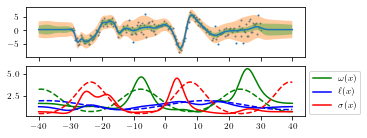

In [6]:
latexify(fig_width=5, fig_height=2)
#     latexify(fig_width=10, fig_height=6)
mpl.rcParams['lines.markersize'] = 1

pred_noise = gp.noise(best_params, X_test)

std2 = (jnp.diag(pred_cov) ** 0.5) * 2
std2_epi = ((jnp.diag(pred_cov) - pred_noise) ** 0.5) * 2


fig, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.scatter(X, y, label="Data");
idx = jnp.argsort(X_test.ravel())
ax.plot(X_test.ravel()[idx], pred_mean.ravel()[idx], label="Pred. mean");
ax.fill_between(X_test.ravel()[idx], pred_mean.ravel()[idx]-std2[idx], pred_mean.ravel()[idx]+std2[idx], alpha=0.4, label="Total uncertainty");
ax.fill_between(X_test.ravel()[idx], pred_mean.ravel()[idx]-std2_epi[idx], pred_mean.ravel()[idx]+std2_epi[idx], alpha=0.4, label="Epistemic uncertainty");
# ax.legend(bbox_to_anchor=(1,1));
# ax.set_ylim(-1.5, 3.8)

ax = axes[1]
if flex_noise:
    ax.plot(X_test, pred_noise, label=r"$\omega(x)$", color='g')
    ax.plot(X_test, func_dict['noise'](X_test), '--', color='g')
if flex_scale:
    ax.plot(X_test, gp.kernel.predict_scale(best_params, X_test).ravel(), label=r"$\ell(x)$", color='b')
    ax.plot(X_test, func_dict['scale'](X_test), '--', color='b')
if flex_var:
    ax.plot(X_test, gp.kernel.predict_var(best_params, X_test).ravel(), label=r"$\sigma(x)$", color='r')
    ax.plot(X_test, func_dict['var'](X_test), '--', color='r')
#     ax.plot(X_test, varf(X_test), label='True var')
ax.legend(bbox_to_anchor=(1,1));
